# Connect Forest Management Model with Forest Carbon Budget Model (without calibration)

## Set up Modelling Environment

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import ws3.forest
import time
import gurobipy as grb
from util_opt import compile_scenario_maxstock, plot_scenario_maxstock, run_cbm_maxstock, cbm_report, plugin_c_curves, compare_ws3_cbm, compile_events
import pickle
# Import Module
from util_opt import compile_scenario_maxstock, plot_scenario_maxstock, run_cbm_maxstock, run_scenario, plugin_c_curves_both, cbm_report_both, compare_ws3_cbm_both, track_system_stock, track_system_emission, compile_scenario_minemission, plot_scenario_minemission
import libcbm

## Create and Run `ForestModel` instance

In [2]:
base_year = 2020
horizon = 10
period_length = 10
max_age = 1000
n_steps = 100
tvy_name = 'totvol'
case_study = 'redchris'

In [3]:
fm = ws3.forest.ForestModel(model_name='redchris',
                            model_path='./data/woodstock_model_files_redchris_test',
                            # model_path='./data/woodstock_model_files_redchris',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()

fm.grow()

In [4]:
# Flag 'harvest' as a harvesting action in the ws3 model
harvest_acode='harvest'
fm.actions[harvest_acode].is_harvest = True

(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Harvested area'}, xlabel='Period', ylabel='Area (ha)'>,
        <Axes: title={'center': 'Harvested volume'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Growing Stock'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Ecosystem C stock'}, xlabel='Period', ylabel='Stock (ton)'>],
       dtype=object))

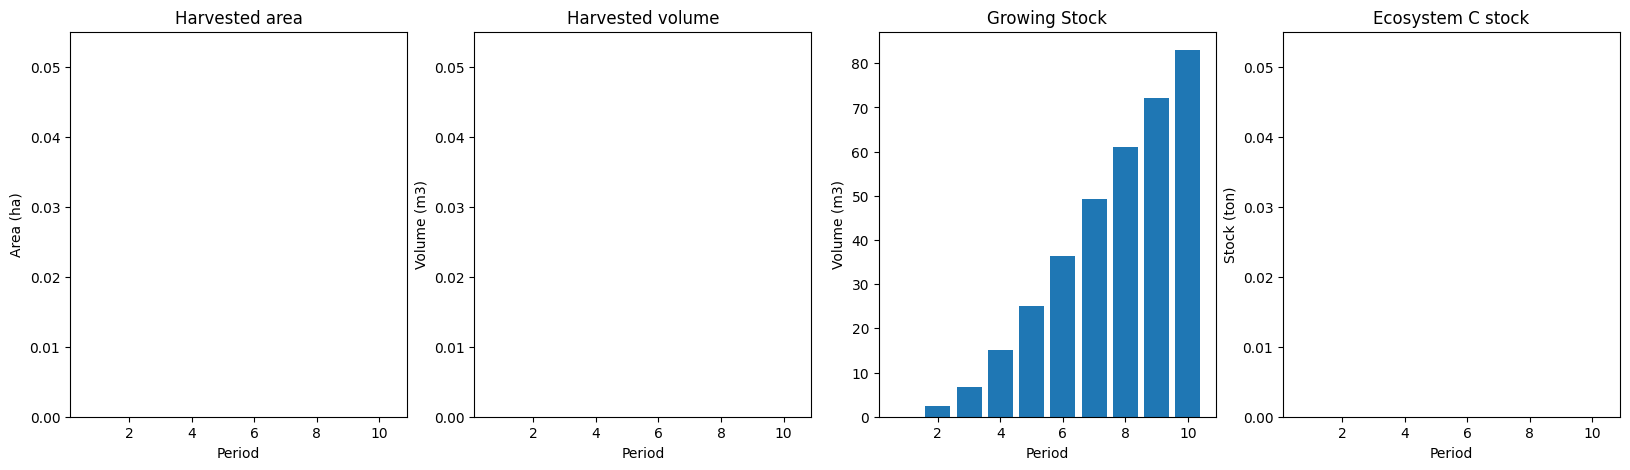

In [5]:
# Check the Forest Inventory of the Forest Model
df = compile_scenario_maxstock(fm)
plot_scenario_maxstock(df)

## Hard-link `ForestModel` to `libcbm`

Prepare CBM input files

In [6]:
# Define Disturance Types
disturbance_type_mapping = [{'user_dist_type': 'harvest', 'default_dist_type': 'Clearcut harvesting without salvage'},
                            {'user_dist_type': 'fire', 'default_dist_type': 'Wildfire'}]
for dtype_key in fm.dtypes:
    fm.dt(dtype_key).last_pass_disturbance = 'fire' if dtype_key[2] == dtype_key[4] else 'harvest'

In [7]:
sit_config, sit_tables = fm.to_cbm_sit(softwood_volume_yname='swdvol', 
                                       hardwood_volume_yname='hwdvol', 
                                       admin_boundary='British Columbia', 
                                       eco_boundary='Montane Cordillera',
                                       disturbance_type_mapping=disturbance_type_mapping)

Here are other two ways to generate sit tables. But they are only suitbale for small forest model since they take too much running time and memory

In [8]:
# Define Time Steps
n_steps = fm.horizon * fm.period_length

# Run CBM and Generate CBM 0utputs
cbm_output = run_cbm_maxstock(sit_config, sit_tables, n_steps)

Emissions from all biomass components only resulting from fire disturbance, while these from all DOM pools resulting from annual decay processes and fire disturbance.

In [9]:
# Define Carbon Pools
biomass_pools = ['SoftwoodMerch','SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots','SoftwoodFineRoots',                        
                 'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther', 'HardwoodCoarseRoots', 'HardwoodFineRoots']
dom_pools = ['AboveGroundVeryFastSoil', 'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
             'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil', 'SoftwoodStemSnag', 'SoftwoodBranchSnag',
             'HardwoodStemSnag', 'HardwoodBranchSnag']
emissions_pools = ['CO2', 'CH4', 'CO', 'NO2']
products_pools = ['Products']
ecosystem_pools = biomass_pools + dom_pools
all_pools = biomass_pools + dom_pools + emissions_pools + products_pools

In [10]:
# Define Carbon Fluxes
annual_process_fluxes = [
    'DecayDOMCO2Emission',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]


npp_fluxes=[
    'DeltaBiomass_AG', 
    'DeltaBiomass_BG'
]

# decay_emissions_fluxes = [
#     'DecayVFastAGToAir',
#     'DecayVFastBGToAir',
#     'DecayFastAGToAir',
#     'DecayFastBGToAir',
#     'DecayMediumToAir',
#     'DecaySlowAGToAir',
#     'DecaySlowBGToAir',
#     'DecaySWStemSnagToAir',
#     'DecaySWBranchSnagToAir',
#     'DecayHWStemSnagToAir',
#     'DecayHWBranchSnagToAir'
# ]
ecosystem_decay_emissions_pools = [
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir']

disturbance_production_fluxes = [
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction'   
]

disturbance_emissions_fluxes = [
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'   
]

all_fluxes = [
    'DisturbanceCO2Production',
    'DisturbanceCH4Production',
    'DisturbanceCOProduction',
    'DisturbanceBioCO2Emission',
    'DisturbanceBioCH4Emission',
    'DisturbanceBioCOEmission',
    'DecayDOMCO2Emission',
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir',
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceDOMCO2Emission',
    'DisturbanceDOMCH4Emission',
    'DisturbanceDOMCOEmission',
    'DisturbanceMerchLitterInput',
    'DisturbanceFolLitterInput',
    'DisturbanceOthLitterInput',
    'DisturbanceCoarseLitterInput',
    'DisturbanceFineLitterInput',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'
]
grossgrowth_ag = [
    "DeltaBiomass_AG",
    "TurnoverMerchLitterInput",
    "TurnoverFolLitterInput",
    "TurnoverOthLitterInput",
]

grossgrowth_bg = [
    "DeltaBiomass_BG",
    "TurnoverCoarseLitterInput",
    "TurnoverFineLitterInput",
]

product_flux = [
     "DisturbanceSoftProduction",
     "DisturbanceHardProduction",
     "DisturbanceDOMProduction",
]

ecosystem_decay_emissions_pools = [
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir']
GrossGrowth_pools = [
    'DeltaBiomass_AG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'DeltaBiomass_BG',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput']

GrossGrowth_AG = flux[[
        "DeltaBiomass_AG",
        "TurnoverMerchLitterInput",
        "TurnoverFolLitterInput",
        "TurnoverOthLitterInput",
        ]].sum(axis=1)

GrossGrowth_BG = flux[[
        "DeltaBiomass_BG",
        "TurnoverCoarseLitterInput",
        "TurnoverFineLitterInput",
        ]].sum(axis=1)

In [11]:
# Define Sum Carbon Pools and Sum Carbon Fluxes
pools = ecosystem_pools
# fluxes = decay_emissions_fluxes + disturbance_emissions_fluxes
# gross_growth = grossgrowth_ag + grossgrowth_bg
fluxes = ecosystem_decay_emissions_pools
gross_growth = GrossGrowth_pools
sum_pools = ['ecosystem', 'biomass', 'DOM']

,Biomass,DOM,Ecosystem,All_Emissions,Gross_Growth,Stock_Change
Year,,,,,,
0,0.598223,148.688416,149.286639,0.000000,0.000000,0.000000
1,1.425991,145.871285,147.297277,2.938317,0.948955,1.989362
2,2.359417,143.311503,145.670920,2.769552,1.143195,1.626357
3,3.360585,140.974650,144.335235,2.638109,1.302424,1.335685
4,4.408365,138.833654,143.242018,2.534775,1.441559,1.093217
...,...,...,...,...,...,...
96,59.689108,115.589801,175.278909,2.661061,3.116596,-0.455535
97,60.037326,115.698885,175.736211,2.665952,3.123254,-0.457302
98,60.385022,115.810247,176.195268,2.670828,3.129886,-0.459057


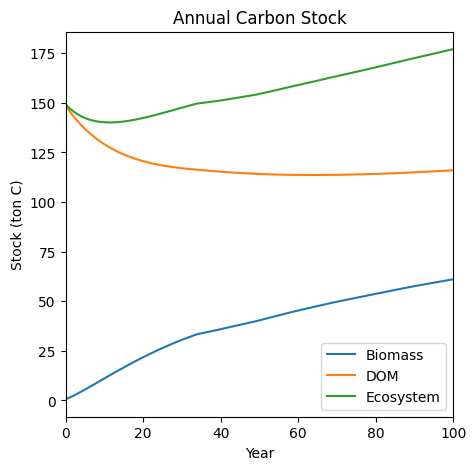

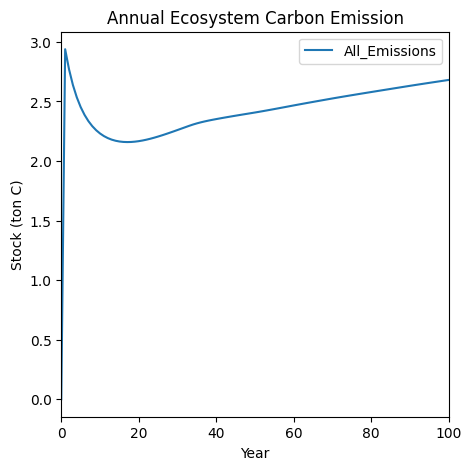

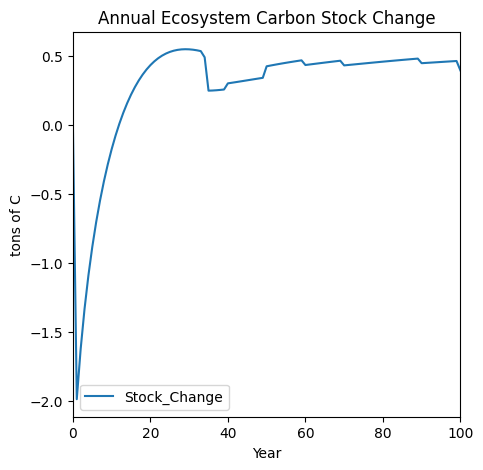

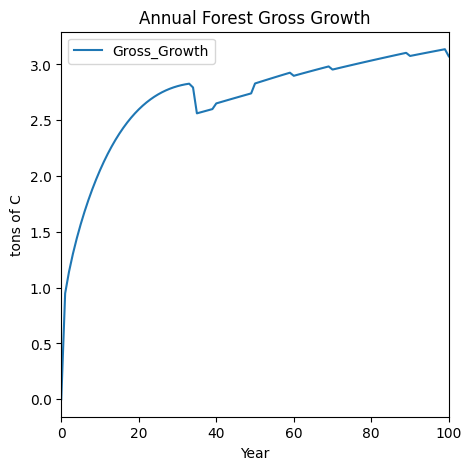

In [12]:
# Report Annual CBM Results
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes, gross_growth)

## Plug-in Carbon Yield Curves

In [13]:
# Read curves
c_curves_p = pd.read_pickle("./redchris_c_curves_p_test.pkl")
# c_curves_p = pd.read_pickle("./redchris_c_curves_p_exactmatch.pkl")
c_curves_f = pd.read_pickle("./redchris_c_curves_f_test.pkl")

In [14]:
# In order to reduce the impact of DOM input
# c_curves_p.loc[:59, 'DOM'] = c_curves_p.loc[:59, 'DOM'] * 0.1
# c_curves_p['ecosystem'] = c_curves_p['DOM'] + c_curves_p['biomass']

In [15]:
# Plug carbon yield curves into forest model
# plugin_c_curves(fm, c_curves_p, pools=sum_pools)
plugin_c_curves_both(fm, c_curves_p, c_curves_f, pools=sum_pools, fluxes=['net_emissions', 'total_emissions', 'gross_growth'])

found match for mask ('?', '?', '?', '?', '7', '7')


In [16]:
# Check if all carbon yield curves are plugged in well.
fm.yields

[(('?', '?', '?', '?', '?', '?'), '', []),
 (('?', '?', '?', '?', '7', '7'),
  'a',
  [('s0100', <ws3.core.Curve at 0x7f7d7889de40>),
   ('ecosystem', <ws3.core.Curve at 0x7f7d729a8eb0>),
   ('biomass', <ws3.core.Curve at 0x7f7d729a8be0>),
   ('DOM', <ws3.core.Curve at 0x7f7d729a9210>),
   ('net_emissions', <ws3.core.Curve at 0x7f7d729a9390>),
   ('total_emissions', <ws3.core.Curve at 0x7f7d729a9690>),
   ('gross_growth', <ws3.core.Curve at 0x7f7d729a97e0>)]),
 (('?', '?', '?', '?', '?', '?'),
  'c',
  [('totvol', '_SUM(s0100)'),
   ('swdvol', '_SUM(s0100)'),
   ('hwdvol', '_SUM()')])]

(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Harvested area'}, xlabel='Period', ylabel='Area (ha)'>,
        <Axes: title={'center': 'Harvested volume'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Growing Stock'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Ecosystem C stock'}, xlabel='Period', ylabel='Stock (ton)'>],
       dtype=object))

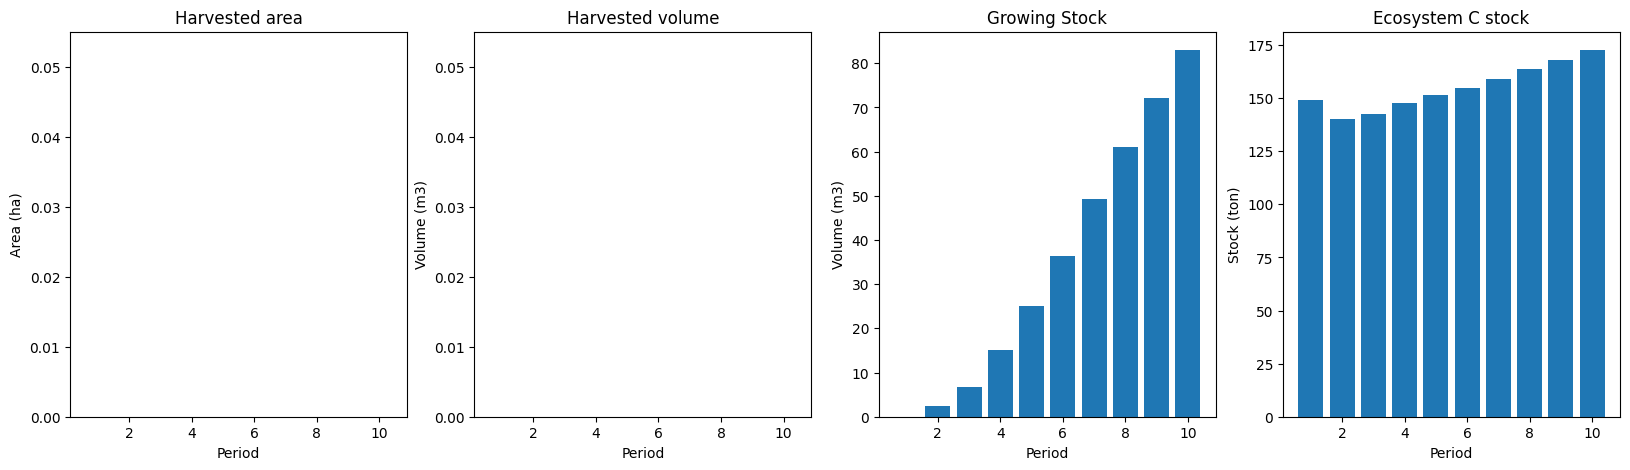

In [17]:
# Check the Forest Inventory of the ws3 Model without harvesting
df = compile_scenario_maxstock(fm)
plot_scenario_maxstock(df)

## No-harvest

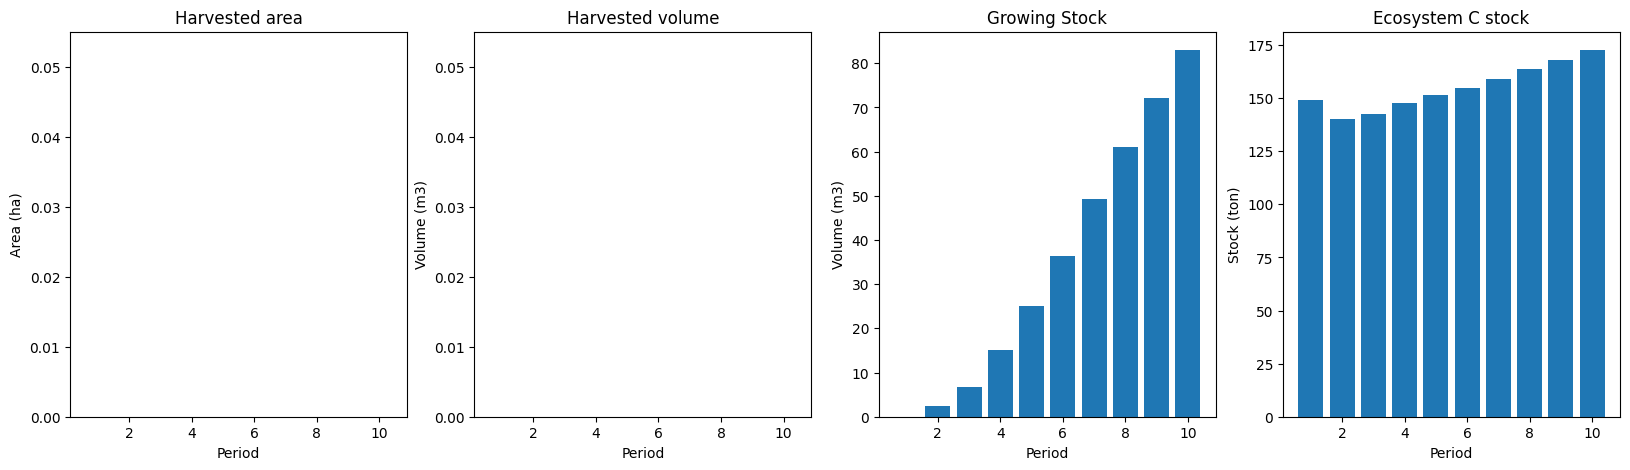

In [18]:
df = compile_scenario_maxstock(fm)
fig, ax = plot_scenario_maxstock(df)

In [19]:
#Define Basic Variables
softwood_volume_yname='swdvol' 
hardwood_volume_yname='hwdvol'
n_yield_vals=100

In [20]:
#Generate New Sit_events file
sit_events = compile_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [21]:
# Replace the Sit_events file in the sit tables
sit_tables['sit_events'] = sit_events

In [22]:
sit_events

,theme0,theme1,theme2,theme3,theme4,theme5,species,using_age_class,min_softwood_age,max_softwood_age,...,MinSWMerchStemSnagC,MaxSWMerchStemSnagC,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,disturbance_year


In [23]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm_maxstock(sit_config, sit_tables, n_steps)

,Biomass,DOM,Ecosystem,All_Emissions,Gross_Growth,Stock_Change,Net_Emissions
Year,,,,,,,
0,0.598223,148.688416,149.286639,0.000000,0.000000,0.000000,0.000000
1,1.425991,145.871285,147.297277,10.773830,-3.479501,1.989362,7.294328
2,2.359417,143.311503,145.670920,10.155024,-4.191715,1.626357,5.963309
3,3.360585,140.974650,144.335235,9.673067,-4.775556,1.335685,4.897511
4,4.408365,138.833654,143.242018,9.294176,-5.285715,1.093217,4.008461
...,...,...,...,...,...,...,...
96,59.689108,115.589801,175.278909,9.757222,-11.427518,-0.455535,-1.670296
97,60.037326,115.698885,175.736211,9.775157,-11.451933,-0.457302,-1.676775
98,60.385022,115.810247,176.195268,9.793037,-11.476248,-0.459057,-1.683211


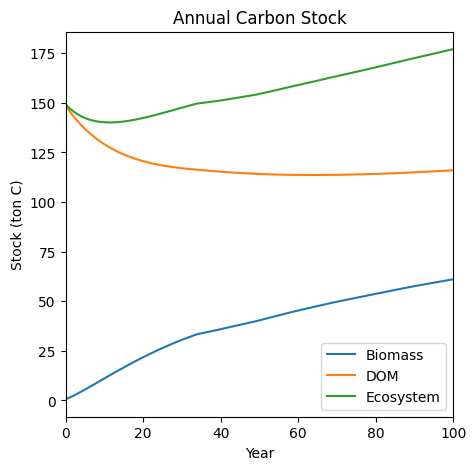

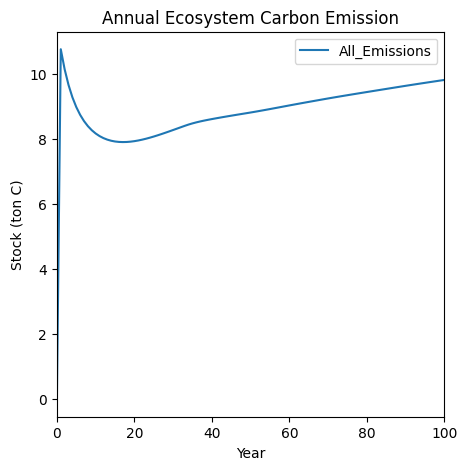

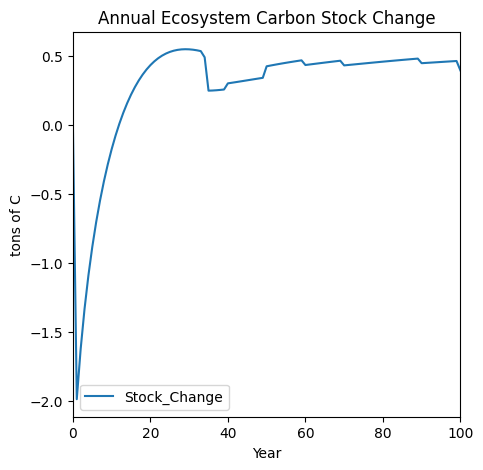

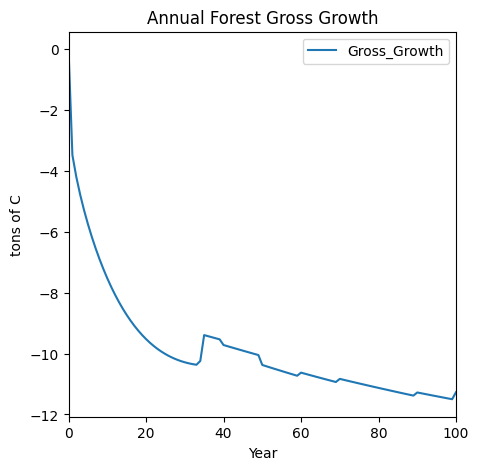

In [24]:
# Report Annual CBM Outputs
# cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes, gross_growth)
cbm_report_both(fm, cbm_output, biomass_pools, dom_pools, fluxes, gross_growth)

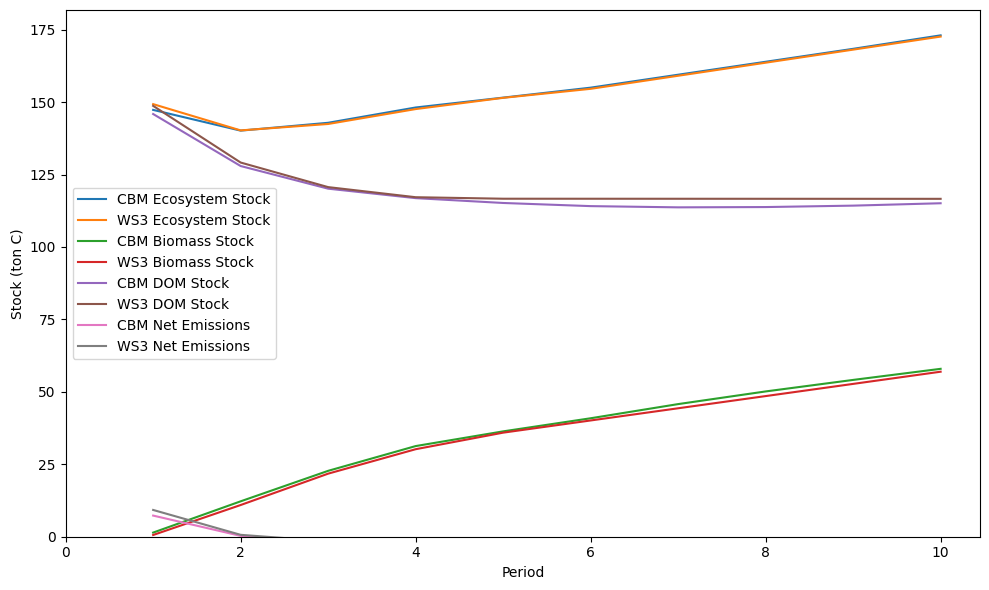

(   period  biomass_stock   dom_stock   eco_stock  ecosystem_decay_emissions  \
 0       1       1.425991  145.871285  147.297277                  10.773830   
 1       2      12.216141  127.925020  140.141161                   8.100525   
 2       3      22.738206  120.109478  142.847683                   7.964714   
 3       4      31.279952  116.844679  148.124632                   8.330160   
 4       5      36.356700  115.175885  151.532585                   8.645467   
 5       6      40.879661  114.088861  154.968523                   8.846447   
 6       7      45.767698  113.666607  159.434305                   9.066074   
 7       8      50.136422  113.766280  163.902702                   9.279206   
 8       9      54.112593  114.256576  168.369169                   9.475605   
 9      10      57.939955  115.079056  173.019010                   9.666118   
 
    gross_growth  net_emissions  eco_stock_change  
 0     -3.479501       7.294328          0.000000  
 1     -7.8062

In [25]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
# compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, plots='whole')
compare_ws3_cbm_both(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, ecosystem_decay_emissions_pools, GrossGrowth_pools, plots="whole")

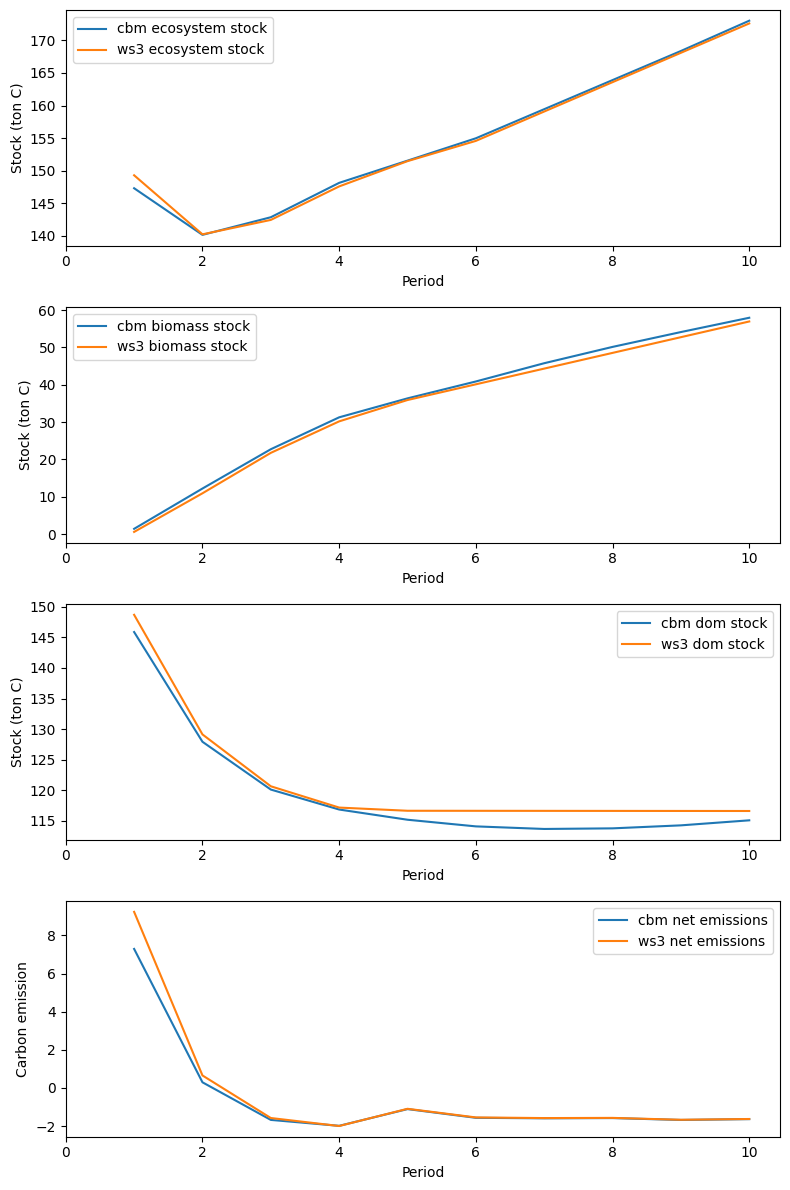

(   period  biomass_stock   dom_stock   eco_stock  ecosystem_decay_emissions  \
 0       1       1.425991  145.871285  147.297277                  10.773830   
 1       2      12.216141  127.925020  140.141161                   8.100525   
 2       3      22.738206  120.109478  142.847683                   7.964714   
 3       4      31.279952  116.844679  148.124632                   8.330160   
 4       5      36.356700  115.175885  151.532585                   8.645467   
 5       6      40.879661  114.088861  154.968523                   8.846447   
 6       7      45.767698  113.666607  159.434305                   9.066074   
 7       8      50.136422  113.766280  163.902702                   9.279206   
 8       9      54.112593  114.256576  168.369169                   9.475605   
 9      10      57.939955  115.079056  173.019010                   9.666118   
 
    gross_growth  net_emissions  eco_stock_change  
 0     -3.479501       7.294328          0.000000  
 1     -7.8062

In [26]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
# compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, plots='individual')
compare_ws3_cbm_both(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, ecosystem_decay_emissions_pools, GrossGrowth_pools, plots="individual")

## Maximize the Total System Carbon Stock and Minimze Net Carbon Emission

In [35]:
def select_obj(obj_mode):
    print(f"Selected scenario: {obj_mode}")
obj_dropdown = widgets.Dropdown(
    options=['max_hv', 'min_ha', 'max_st', 'min_em'],
    value='min_em',
    description='Objective:'
)
display(obj_dropdown)
obj_dropdown.observe(lambda change: select_obj(change['new']), names='value')

Dropdown(description='Objective:', index=3, options=('max_hv', 'min_ha', 'max_st', 'min_em'), value='min_em')

In [36]:
obj_mode = obj_dropdown.value

In [37]:
from util_opt import cmp_c_ss, cmp_c_se

running no constraints scenario
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /media/data/home/eghasemi/.virtualenvs/foo/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/9fc2cbd52fd744d9a8a24c1afcb4fd76-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/9fc2cbd52fd744d9a8a24c1afcb4fd76-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 6 COLUMNS
At line 2055 RHS
At line 2057 BOUNDS
At line 3082 ENDATA
Problem MODEL has 1 rows, 1024 columns and 1024 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 0 (-1) rows, 0 (-1024) columns and 0 (-1024) elements
Empty problem - 0 rows, 0 columns and 0 elements
Optimal - objective value -11.405063
After Postsolve, objective -11.405063, infeasibilities - dual 14.580649 (4), primal 0 (0)
Presolved model was optimal, full model needs cleaning up
0  Obj -11.405063 Dual inf 14.580649 (4)
1  O

[(('tsa04', '1', '7', '100', '7', '7'), 1, 1.0, 'harvest', 1, '_existing')]

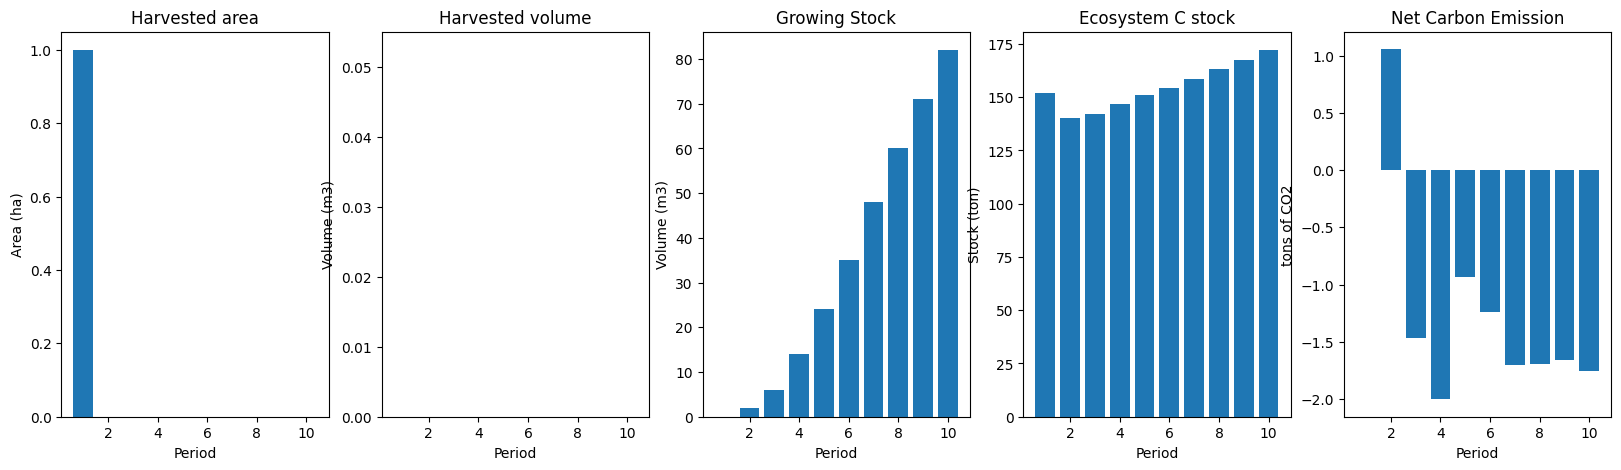

In [38]:
# Maximize Harvest
# run_scenario(fm, obj_mode , 'no_cons', solver='gurobi')
run_scenario(fm, obj_mode , 'no_cons') #using pulp

running no constraints scenario
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1 rows, 1024 columns and 1024 nonzeros
Model fingerprint: 0xb38bc51c
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 1 rows and 1024 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1405063e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.140506315e+01


[(('tsa04', '1', '7', '100', '7', '7'), 1, 1.0, 'harvest', 1, '_existing')]

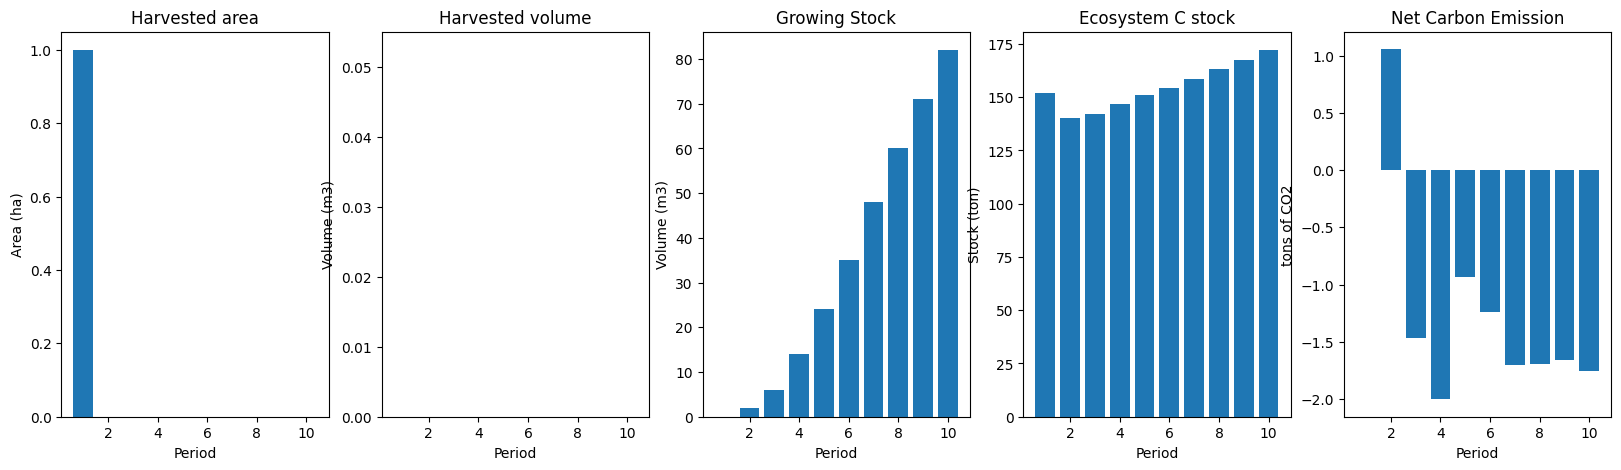

In [39]:
# Maximize Harvest
run_scenario(fm, obj_mode , 'no_cons', solver='gurobi')
# run_scenario(fm, obj_mode , 'no_cons') #using pulp

In [32]:
# fm.applied_actions

(<Figure size 1600x400 with 5 Axes>,
 array([<Axes: title={'center': 'Solid Wood Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Paper Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Total Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Ecosystem C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Total System C Stock'}, xlabel='Period', ylabel='Stock (tons)'>],
       dtype=object),
    period  solid_wood  paper  sum_product   ecosystem      system
 0       1         0.0    0.0          0.0  149.286639  149.286639
 1       2         0.0    0.0          0.0  140.221424  140.221424
 2       3         0.0    0.0          0.0  142.435132  142.435132
 3       4         0.0    0.0          0.0  147.579891  147.579891
 4       5         0.0    0.0          0.0  151.457129  151.457129
 5       6         0.0    0.0          0.0 

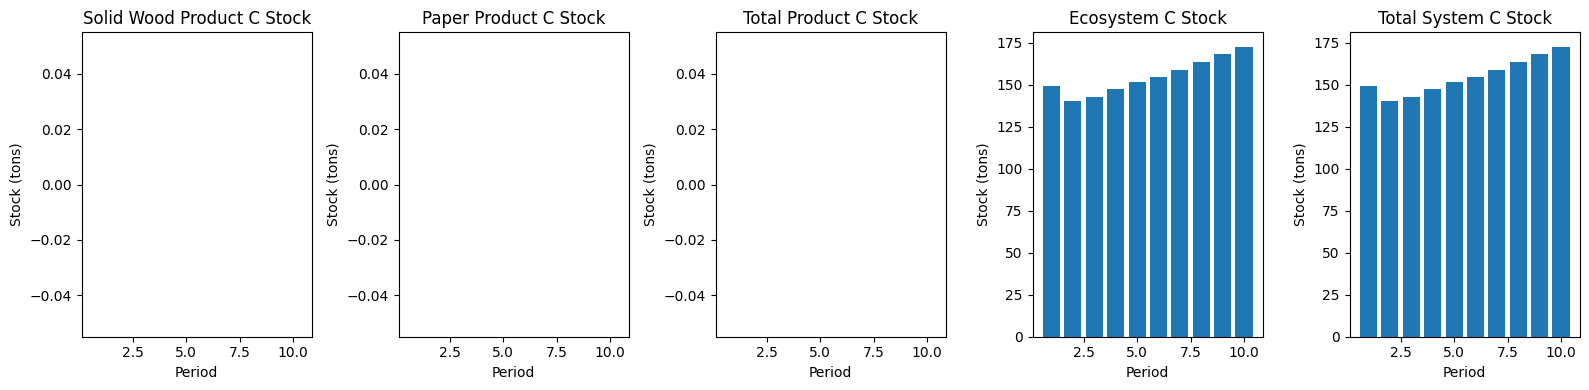

In [33]:
track_system_stock(fm)

(<Figure size 1600x400 with 5 Axes>,
 array([<Axes: title={'center': 'Solid Wood Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Paper Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Total Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Ecosystem CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Total System CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>],
       dtype=object),
    period  solid_wood  paper  sum_product  ecosystem     system
 0       1         0.0    0.0          0.0   0.000000   0.000000
 1       2         0.0    0.0          0.0  33.239123  33.239123
 2       3         0.0    0.0          0.0  -8.116933  -8.116933
 3       4         0.0    0.0          0.0 -18.864114 -18.864114
 4       5         0.0    0.0          0.0 -14.216538 -14.216538
 5       6     

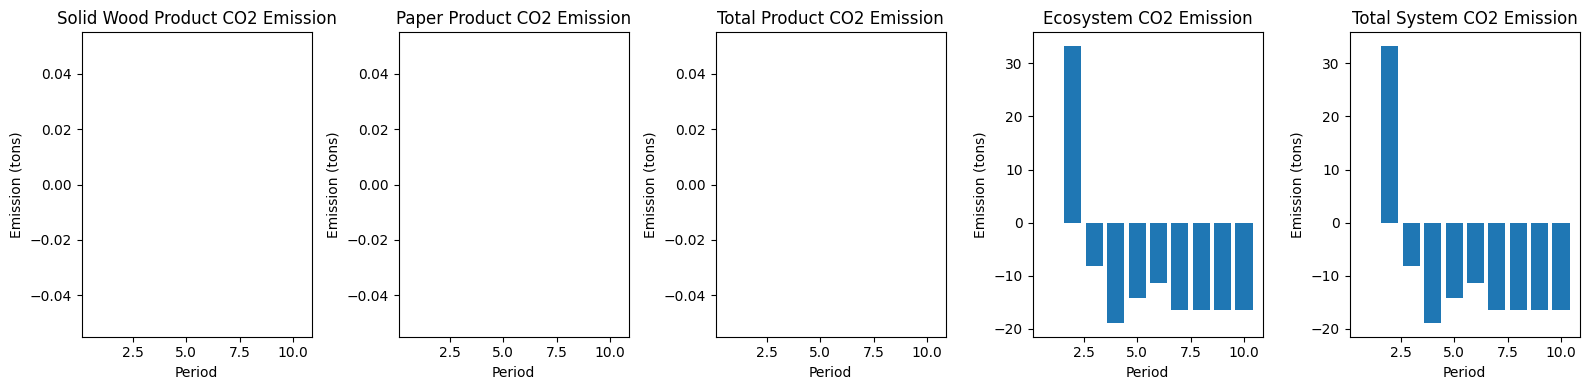

In [34]:
track_system_emission(fm)